Read from a local copy of the ClaimReview Database

### Installation script
```
conda create -n ner python=3.6
source activate ner
conda install -c conda-forge spacy -y
conda install ipython jupyter nb_conda nltk numpy -y
conda install -c conda-forge rake_nltk -y
python -m spacy download en
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_lg
```

In [4]:
import spacy
nlp = spacy.load('en')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [5]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load('en_core_web_sm')
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


In [6]:
fc_path = "fact_checks_20180502.txt"

with open(fc_path) as f:
    fc_raw = f.readlines()

In [7]:
print("No. of Claims:", len(fc_raw))

No. of Claims: 8902


Functions to normalise the text

In [8]:
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def strip_html(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

def clean_text(data):
    text = re.sub(r'[^\w\s]', ' ', data.lower()).replace("\n", "").replace("  ", " ")
    text = "".join([c for c in text if (c.isalpha() or c == " ")])
    text = text.split(" ")
    output = ""
    for word in text:
        if word not in stopwords.words("english"):
            output = output + " " + word
    return output.strip().replace("  ", " ")

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

def norm_text(data,):
    raw = strip_html(data)
    text = clean_text(raw)
    norm_text = lemmatize_sentence(text)
    return norm_text

In [9]:
from rake_nltk import Rake

# Uses stopwords for english from NLTK, and all puntuation characters by
# default
r = Rake()

# Extraction given the text.
r.extract_keywords_from_text("In August 2018, adhesive replicas of President Donald Trump's recently-destroyed star were placed on the Walk of Fame on Hollywood Boulevard.")

# # Extraction given the list of strings where each string is a sentence.
# r.extract_keywords_from_sentences(<list of sentences>)

# To get keyword phrases ranked highest to lowest.
print(r.get_ranked_phrases())

# To get keyword phrases ranked highest to lowest with scores.
print(r.get_ranked_phrases_with_scores())

['president donald trump', 'hollywood boulevard', 'destroyed star', 'august 2018', 'adhesive replicas', 'walk', 'recently', 'placed', 'fame']
[(9.0, 'president donald trump'), (4.0, 'hollywood boulevard'), (4.0, 'destroyed star'), (4.0, 'august 2018'), (4.0, 'adhesive replicas'), (1.0, 'walk'), (1.0, 'recently'), (1.0, 'placed'), (1.0, 'fame')]


In [17]:
text = "Dwayne Johnson is dead. Neil Peart is being replaced."

In [25]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from rake_nltk import Rake

nlp = spacy.load('en_core_web_lg')

def calculate_similarity_score(value_mesh, r1_scored, r2_scored):
    similarity_array = np.maximum.reduce([row for row in value_mesh[0]])
    weighted_similarity = np.multiply(similarity_array, [keyword_tuple[0] for keyword_tuple in r1_scored])
    weighted_similarity_sum = np.sum(weighted_similarity)
    sum_of_weights = np.sum([keyword_tuple[0] for keyword_tuple in r1_scored])
    weighted_similarity_sum_over_weights = weighted_similarity_sum/sum_of_weights
    return weighted_similarity_sum_over_weights

def phrase_vect(text):
    tokens = nlp(text)
    maxpool = np.maximum.reduce([token.vector for token in tokens])
    return maxpool
#     minpool = np.minimum.reduce([token.vector for token in tokens])
#     # https://stackoverflow.com/questions/21816433/
#     result = np.concatenate((minpool,maxpool))
#     return result

def meshgrid(x,y): # DW code !!!
    return (
        [[x_ for x_ in x] for  _ in y],
        [[y_ for  _ in x] for y_ in y])

def cosine(u,v):
#     print(np.shape(u))
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

def calculate_claim_text(claim, text):
    r1 = Rake()
    r1.extract_keywords_from_text(claim)
    r1_scored = r1.get_ranked_phrases_with_scores()
    print(r1_scored)

    r2 = Rake()
    r2.extract_keywords_from_text(text)
    r2_scored = r2.get_ranked_phrases_with_scores()
    print(r2_scored)
    
    # assign vectors
    r1_scored_vec = [[claim_keyword_tuple[0], 
                      claim_keyword_tuple[1], 
                      phrase_vect(claim_keyword_tuple[1])] for claim_keyword_tuple in r1_scored]
#     print(len(r1_scored_vec))
#     print(len(r1_scored_vec[0]))

    r2_scored_vec = [[text_keyword_tuple[0], 
                      text_keyword_tuple[1], 
                      phrase_vect(text_keyword_tuple[1])] for text_keyword_tuple in r2_scored]
#     print(len(r1_scored_vec))
#     print(len(r1_scored_vec[0]))
    
    
    # compare statements

    pair_mesh = meshgrid(r1_scored_vec, r2_scored_vec)
    value_mesh = meshgrid([0]*len(r1_scored_vec), [0]*len(r2_scored_vec))

    import numpy as np
    for i,_ in enumerate(pair_mesh[0]):
        for j,_ in enumerate(pair_mesh[0][0]): 
            vector1 = pair_mesh[0][i][j][2]
            vector2 = pair_mesh[1][i][j][2]

            value_mesh[0][i][j] = cosine(vector1, vector2)
            
    return calculate_similarity_score(value_mesh, r1_scored, r2_scored)

100
Claim: Actor Jim Carrey said that the United States is "morally upside down."
[(16.0, 'actor jim carrey said'), (4.0, 'united states'), (4.0, 'morally upside'), (1.0, '."')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.4567949366569519
Claim: Liberty University students "were mandated" to attend Sen. Ted Cruz’s presidential announcement "or they would be fined."
[(9.0, 'ted cruz ’'), (9.0, 'liberty university students'), (4.0, 'presidential announcement'), (4.0, 'fined ."'), (4.0, 'attend sen'), (1.0, 'would'), (1.0, 'mandated')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.3868516511283815
Claim: A photograph shows a baseball stadium repurposed as a residential neighborhood.
[(9.0, 'baseball stadium repurposed'), (4.0, 'residential neighborhood'), (4.0, 'photograph shows')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.3002998092595269
Claim: Folding a $5 bill in a spec

/anaconda3/envs/ner/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in float_scalars
/anaconda3/envs/ner/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in reduce


nan
Claim: The KKK started a petition to "purge' black people in the United States.
[(4.0, 'united states'), (4.0, 'kkk started'), (4.0, 'black people'), (1.0, 'purge'), (1.0, 'petition')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.3624955394438335
Claim: An Article accurately compares the salaries of top executives of several large charitable organizations.
[(16.0, 'several large charitable organizations'), (9.0, 'article accurately compares'), (4.0, 'top executives'), (1.0, 'salaries')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.25178478186329206
Claim: Tuberculosis recently passed "HIV/AIDS as the leading infectious killer globally."
[(25.0, 'leading infectious killer globally ."'), (9.0, 'tuberculosis recently passed'), (1.0, 'hiv'), (1.0, 'aids')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.340877296610011
Claim: "I never once asked that (Megyn Kelly) be removed" 

[(9.0, 'advanced countries ...'), (4.0, 'mass violence'), (4.0, 'frequency ."'), (1.0, 'type'), (1.0, 'kind'), (1.0, 'happen')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.30739732533693315
Claim: Musician Kanye West is wanted by police for a jewelry "insurance scam."
[(9.0, 'musician kanye west'), (9.0, 'insurance scam ."'), (1.0, 'wanted'), (1.0, 'police'), (1.0, 'jewelry')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.4332529306411743
Claim: Children’s TV host Barney the purple dinosaur was caught with cocaine hidden in his tail and cussed out a child.
[(9.0, 'tv host barney'), (4.0, 'purple dinosaur'), (4.0, 'cocaine hidden'), (4.0, 'children ’'), (1.0, 'tail'), (1.0, 'cussed'), (1.0, 'child'), (1.0, 'caught')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.37289964377880097
Claim: A shelter rented dogs for embarrassed adult Pokemon Go players and raked in tons of cash b

0.42866288351290155
Claim: “What about that Betsy DeVos? A billionaire who he is picking to head Education who has never seen the inside of a classroom."
[(4.0, 'never seen'), (4.0, 'head education'), (4.0, 'classroom ."'), (4.0, 'betsy devos'), (1.0, '“'), (1.0, 'picking'), (1.0, 'inside'), (1.0, 'billionaire')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.36355294585227965
Claim: Maps shows that areas with high democratic populations also have high crime rates.
[(15.5, 'high democratic populations also'), (9.5, 'high crime rates'), (4.0, 'maps shows'), (1.0, 'areas')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.32551726549863813
Claim: Summary of 1956 Republican platform describes a significant divergence from the party's focus in recent decades.
[(16.0, '1956 republican platform describes'), (4.0, 'significant divergence'), (4.0, 'recent decades'), (1.0, 'summary'), (1.0, 'party'), (1.0, 'focus')]
[(4.0, 'n

0.46338497654155447
Claim: Director Michael Moore was accused of sexual harassment by a 16-year-old film extra.
[(9.0, 'old film extra'), (9.0, 'director michael moore'), (4.0, 'sexual harassment'), (1.0, 'year'), (1.0, 'accused'), (1.0, '16')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.42918872833251953
Claim: President Trump "vetoed" Argentina's decision to honor Jimmy Carter in April 2017.
[(9.0, 'honor jimmy carter'), (4.0, 'president trump'), (4.0, 'april 2017'), (1.0, 'vetoed'), (1.0, 'decision'), (1.0, 'argentina')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.42020189166069033
Claim: A lesbian was removed from a women's bathroom by police in North Carolina because she wasn't feminine enough.
[(4.0, 'north carolina'), (4.0, 'feminine enough'), (1.0, 'women'), (1.0, 'removed'), (1.0, 'police'), (1.0, 'lesbian'), (1.0, 'bathroom')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, '

[(25.0, '15 million new jobs ."'), (16.0, 'president barack obama ’'), (4.0, 'united states'), (1.0, 'tenure'), (1.0, 'says'), (1.0, 'created')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.379766629387935
Claim: The International Astronomical Union (IAU) issued a press release stating that Pluto has been reclassified as a planet.
[(9.0, 'press release stating'), (9.0, 'international astronomical union'), (1.0, 'reclassified'), (1.0, 'pluto'), (1.0, 'planet'), (1.0, 'issued'), (1.0, 'iau')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.3354986258175062
Claim: Photograph shows John F. Kennedy and Marilyn Monroe sharing an intimate moment.
[(16.0, 'photograph shows john f'), (9.0, 'marilyn monroe sharing'), (4.0, 'intimate moment'), (1.0, 'kennedy')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.49267991781234743
Claim: "California is 49th out of 50 in the United States in per 

0.4141675169495019
Claim: "There's no such thing as a lone wolf. ... That was a phrase invented by the last administration to make Americans stupid."
[(16.0, 'make americans stupid ."'), (4.0, 'phrase invented'), (4.0, 'lone wolf'), (4.0, 'last administration'), (1.0, 'thing'), (1.0, '...')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.3729290505250295
Claim: "One in three people who’s receiving treatment for (opioid) drug problems gets some help from Medicaid to pay for that."
[(9.0, 'drug problems gets'), (4.0, 'three people'), (4.0, 'receiving treatment'), (1.0, '’'), (1.0, 'pay'), (1.0, 'opioid'), (1.0, 'one'), (1.0, 'medicaid'), (1.0, 'help'), (1.0, '."')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.31866788181165856
Claim: "While (women) represent 47 percent of the overall work force, we only make up 23 percent of STEM-related occupations."
[(9.0, 'related occupations ."'), (9.0, 'overall work force'), (

0.3060492269694805
Claim: New York has "the biggest outmigration of citizens of any state."
[(4.0, 'state ."'), (4.0, 'new york'), (4.0, 'biggest outmigration'), (1.0, 'citizens')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.33865979313850403
Claim: "State economic development dollars were used to support a project where goods were manufactured in China."
[(16.0, 'state economic development dollars'), (4.0, 'china ."'), (1.0, 'used'), (1.0, 'support'), (1.0, 'project'), (1.0, 'manufactured'), (1.0, 'goods')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.34002052128314975
Claim: "Since 2012," city of Austin "property taxes have gone up almost 30 percent while incomes have only risen 4 percent."
[(16.0, 'since 2012 ," city'), (15.5, 'risen 4 percent ."'), (9.5, 'almost 30 percent'), (4.0, 'property taxes'), (1.0, 'incomes'), (1.0, 'gone'), (1.0, 'austin')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'rep

nan
Claim: The 9/11 terrorist attacks trapped a World Trade Center employee inadvertently revealing his adulterous activities to his wife.
[(36.0, 'world trade center employee inadvertently revealing'), (16.0, '11 terrorist attacks trapped'), (4.0, 'adulterous activities'), (1.0, 'wife'), (1.0, '9')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.3693154438816268
Claim: The Clintons were forced to return an estimated $200,000 in furniture, china and art they "stole" from the White House.
[(4.0, 'white house'), (1.0, 'stole'), (1.0, 'return'), (1.0, 'furniture'), (1.0, 'forced'), (1.0, 'estimated'), (1.0, 'clintons'), (1.0, 'china'), (1.0, 'art'), (1.0, '200'), (1.0, '000')]
[(4.0, 'neil peart'), (4.0, 'dwayne johnson'), (1.0, 'replaced'), (1.0, 'dead')]
0.29621162371976034
Claim: Ted Cruz blamed God for his failed presidential campaign on Twitter.
[(16.0, 'ted cruz blamed god'), (9.0, 'failed presidential campaign'), (1.0, 'twitter')]
[(4.0, 'neil pe

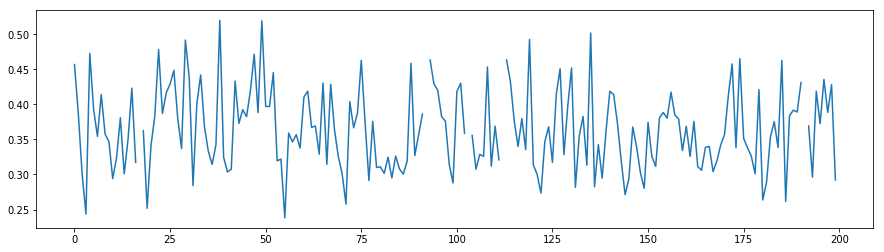

In [26]:
import numpy as np
random_point = np.random.randint(len(fc_raw)-200)
random_point = 100
print(random_point)

similarity_array = []

for fc in fc_raw[random_point:random_point+200]:
    fc = fc.strip("\n")
    fc = fc.replace("</script>", "").replace('<script type="application/ld+json">', "")
    fc = json.loads(fc)
    claim = fc["claimReviewed"]
#     date_published = fc["datePublished"]
    review_url = fc["url"]
    print("Claim:", claim)
    similarity = calculate_claim_text(claim, text)
    print(similarity)
    similarity_array.append(similarity)
    
plt.figure(figsize=(15,4))
plt.plot(similarity_array)
plt.show()

In [16]:
import numpy as np
random_point = np.random.randint(len(fc_raw)-200)
print(random_point)

for fc in fc_raw[random_point:random_point+200]:
    fc = fc.strip("\n")
    fc = fc.replace("</script>", "").replace('<script type="application/ld+json">', "")
    fc = json.loads(fc)
    claim = fc["claimReviewed"]
#     date_published = fc["datePublished"]
    review_url = fc["url"]
    
    print("Claim:", claim)
    r.extract_keywords_from_text(claim)
    r.get_ranked_phrases()
    print(r.get_ranked_phrases_with_scores())
    doc = nlp(claim)
    print([(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents])
    verbs = set()
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            verbs.add(possible_subject.head)
    print(verbs)
    print()

8018
Claim: A customer found a deep-fried rat head in a Popeyes Chicken meal in Harlem.
[(9.0, 'popeyes chicken meal'), (9.0, 'fried rat head'), (4.0, 'customer found'), (1.0, 'harlem'), (1.0, 'deep')]
[('Popeyes Chicken', 44, 59, 'ORG'), ('Harlem', 68, 74, 'LOC')]
{found}

Claim: Hillary Clinton was reported dead on 11 September 2016, but the news was subsequently covered up and she was replaced by a body double.
[(9.0, '11 september 2016'), (4.0, 'subsequently covered'), (4.0, 'reported dead'), (4.0, 'hillary clinton'), (4.0, 'body double'), (1.0, 'replaced'), (1.0, 'news')]
[('Hillary Clinton', 0, 15, 'PERSON'), ('11 September 2016', 37, 54, 'DATE')]
set()

Claim: "If you don't pay income taxes ... you'll have more money" under the Republican tax plan.
[(16.0, 'pay income taxes ...'), (9.0, 'republican tax plan'), (1.0, 'money')]
[('Republican', 69, 79, 'NORP')]
{pay, have}

Claim: "Sweden. They took in large numbers (of immigrants). They’re having problems like they never thought p

[('Starbucks', 0, 9, 'ORG'), ('$50 or $100', 46, 57, 'MONEY'), ('45th', 86, 90, 'ORDINAL')]
{awarding}

Claim: E-mailed list features Dave Barry's "16 Things It Took Me Over 50+ Years to Learn."
[(25.0, 'mailed list features dave barry'), (4.0, 'learn ."'), (4.0, '16 things'), (1.0, 'years'), (1.0, 'took'), (1.0, 'e'), (1.0, '50')]
[("Dave Barry's", 23, 35, 'PERSON'), ('16', 37, 39, 'CARDINAL'), ('50+ Years to Learn', 63, 81, 'DATE')]
{features, Took}

Claim: "The number of complaints against police officers has decreased from an average when Mr. (Rick) Baker was mayor from 78 to 14."
[(4.0, 'police officers'), (4.0, '14 ."'), (1.0, 'rick'), (1.0, 'number'), (1.0, 'mr'), (1.0, 'mayor'), (1.0, 'decreased'), (1.0, 'complaints'), (1.0, 'baker'), (1.0, 'average'), (1.0, '78')]
[('Rick', 90, 94, 'PERSON'), ('Baker', 96, 101, 'PERSON'), ('78', 117, 119, 'CARDINAL'), ('14', 123, 125, 'CARDINAL')]
{decreased, was}

Claim: The NFL has fined Pittsburgh Steelers players $1 million each for stayin

[('2017', 29, 33, 'DATE'), ('Arctic', 69, 75, 'LOC'), ('Greenland', 111, 120, 'GPE')]
{casts, had}

Claim: Congressman John Lewis didn't pay property taxes on his townhouse in Washington, D.C.
[(9.0, 'pay property taxes'), (9.0, 'congressman john lewis'), (1.0, 'washington'), (1.0, 'townhouse'), (1.0, 'c')]
[('John Lewis', 12, 22, 'PERSON'), ('Washington', 69, 79, 'GPE'), ('D.C.', 81, 85, 'GPE')]
{pay}

Claim: WikiLeaks was caught by Newsweek fabricating e-mails with the intent of damaging the campaign of Hillary Clinton.
[(9.0, 'newsweek fabricating e'), (4.0, 'hillary clinton'), (1.0, 'wikileaks'), (1.0, 'mails'), (1.0, 'intent'), (1.0, 'damaging'), (1.0, 'caught'), (1.0, 'campaign')]
[('WikiLeaks', 0, 9, 'ORG'), ('Newsweek', 24, 32, 'ORG'), ('Hillary Clinton', 97, 112, 'PERSON')]
set()

Claim: Secretary of State John Kerry "funneled" taxpayer money into his daughter's global charity.
[(9.0, 'state john kerry'), (4.0, 'taxpayer money'), (4.0, 'global charity'), (1.0, 'secretary'), (1

[('Hobby Lobby', 4, 15, 'ORG')]
{closing}

Claim: Singer Dolly Parton (or actress Michelle Pfeiffer) said that "Trump in one year is already better than 16 years of Bush and Obama put together"
[(9.0, 'singer dolly parton'), (9.0, 'obama put together'), (9.0, 'actress michelle pfeiffer'), (4.0, 'one year'), (4.0, 'already better'), (4.0, '16 years'), (1.0, 'trump'), (1.0, 'said'), (1.0, 'bush')]
[('Dolly Parton', 7, 19, 'PERSON'), ('Michelle Pfeiffer', 32, 49, 'PERSON'), ('Trump', 62, 67, 'WORK_OF_ART'), ('one year', 71, 79, 'DATE'), ('16 years', 103, 111, 'DATE'), ('Bush', 115, 119, 'PERSON'), ('Obama', 124, 129, 'PERSON')]
{is, said}

Claim: The reaction between metallic mercury and aluminum, which produces a dramatic chain reaction popular on YouTube science channels, is evidence that vaccines are not safe.
[(14.5, 'dramatic chain reaction popular'), (9.0, 'youtube science channels'), (4.0, 'metallic mercury'), (2.5, 'reaction'), (1.0, 'vaccines'), (1.0, 'safe'), (1.0, 'produces'), 

[]
{eat}

Claim: "Adolf Hitler confiscated all the weapons — took all the weapons, had a registry of everybody — and then on the night of June 30, 1934, sent out his secret police and murdered all of his political opponents."
[(9.0, 'political opponents ."'), (9.0, 'adolf hitler confiscated'), (7.5, 'weapons — took'), (4.5, 'everybody —'), (4.0, 'secret police'), (4.0, 'june 30'), (2.0, 'weapons'), (1.0, 'sent'), (1.0, 'registry'), (1.0, 'night'), (1.0, 'murdered'), (1.0, '1934')]
[('Adolf Hitler', 1, 13, 'PERSON'), ('the night of June 30, 1934', 108, 134, 'TIME')]
{confiscated}

Claim: With North Korea, "nobody has ever seen such a positive response on our behalf from China."
[(4.0, 'positive response'), (4.0, 'north korea'), (4.0, 'ever seen'), (4.0, 'china ."'), (1.0, 'nobody'), (1.0, 'behalf')]
[('North Korea', 5, 16, 'GPE'), ('China', 84, 89, 'GPE')]
{seen}

Claim: Melania Trump "liked" a tweet that poked fun at her relationship with her husband, President Donald Trump.
[(8.5, 'pr

[('The Department of Justice', 1, 26, 'ORG'), ('the State Department', 28, 48, 'ORG'), ('FBI', 57, 60, 'ORG'), ('Hillary Clinton', 93, 108, 'PERSON')]
{colluded, look}

Claim: JFK donated his entire presidential salary to charity.
[(9.0, 'entire presidential salary'), (4.0, 'jfk donated'), (1.0, 'charity')]
[('JFK', 0, 3, 'PERSON')]
{donated}

Claim: Former NBA superstar won a hefty award in 2015 after filing suit against a grocery chain that used his name in an advertisement without his permission.
[(9.0, 'former nba superstar'), (4.0, 'hefty award'), (4.0, 'grocery chain'), (4.0, 'filing suit'), (4.0, 'advertisement without'), (1.0, 'used'), (1.0, 'permission'), (1.0, 'name'), (1.0, '2015')]
[('NBA', 7, 10, 'ORG'), ('2015', 42, 46, 'DATE')]
{used, won}

Claim: A distant relative of Donald Trump was a horse thief and a train robber.
[(4.0, 'train robber'), (4.0, 'horse thief'), (4.0, 'donald trump'), (4.0, 'distant relative')]
[('Donald Trump', 22, 34, 'PERSON')]
{was}

Claim: Photogr